In [43]:
import tensorflow as tf
import numpy as np
with np.load("notMNIST.npz") as data :
    Data, Target = data ["images"], data["labels"]
    posClass = 2
    negClass = 9
    dataIndx = (Target==posClass) + (Target==negClass)
    Data = Data[dataIndx]/255.
    Target = Target[dataIndx].reshape(-1, 1)
    Target[Target==posClass] = 1
    Target[Target==negClass] = 0
    np.random.seed(521)
    randIndx = np.arange(len(Data))
    np.random.shuffle(randIndx)
    Data, Target = Data[randIndx], Target[randIndx]
    trainData, trainTarget = Data[:3500], Target[:3500]
    validData, validTarget = Data[3500:3600], Target[3500:3600]
    testData, testTarget = Data[3600:], Target[3600:]

In [58]:
def start_train(n_iterations,learning_rate,fix_decay_regularizer,batch_size):
    
    m, n, k = trainData.shape
    n_epoch = int(n_iterations*batch_size/m)
    
    #Data Handler
    valid_accuracy_log = np.zeros(n_epoch)
    valid_entropy= np.zeros(n_epoch)
    data_accuracy_log = np.zeros(n_epoch)
    data_entropy = np.zeros(n_epoch)
    
    #Test Data (concatenate a 28x28 training data point to 1x(784))
    x_in = tf.placeholder(tf.float32,[None,n*k], name="dataset_in")
    y_in = tf.placeholder(tf.float32, [None,1], name="true_value")
    
    #Validation Data
    valid_data = tf.constant(validData.reshape(-1,n*k),dtype=tf.float32, name="validation_data")
    valid_label = tf.constant(validTarget,dtype=tf.float32, name="validation_label")
    
    #Weights
    w = tf.Variable(tf.zeros([n*k, 1], dtype=np.float32), name="weight")
    b = tf.Variable(tf.zeros([1], dtype=np.float32), name="bias")
    
    if fix_decay_regularizer:
        decaybias = 0
    else:
        decaybias = 0.01 #tf.Variable(0.01, name="decay_regularizer")
    
    #optimizer
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
                
    #Data Loss functions
    y_pred = tf.add(tf.matmul(x_in,w),b)
    loss_weight_decay=tf.nn.l2_loss(w) #0 anyways %loss_weight_decay=h*tf.square(tf.norm(w,ord=2)) #0 anyways
    data_cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(logits= y_pred,labels = y_in)
    data_loss_total = tf.reduce_mean(tf.add(data_cross_entropy,tf.multiply(decaybias,loss_weight_decay)))
    
    #Validation Loss functions
    valid_prediction = (tf.add(tf.matmul(valid_data,w), b))
    valid_cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(logits= valid_prediction,labels = valid_label)
    valid_loss_total = tf.reduce_mean(tf.add(valid_cross_entropy,tf.multiply(decaybias,loss_weight_decay)))
    
    #Validation and Data Loggers
    #since we are a probability, if greater than 50%, set to 1 else set to 0 (thats why we round)
    _, data_acc_log = tf.metrics.accuracy(labels=y_in, predictions=tf.round(tf.sigmoid(y_pred)))
    _, valid_acc_log = tf.metrics.accuracy(labels=valid_label, predictions=tf.round(tf.sigmoid(valid_prediction)))
    
    #Train
    train = optimizer.minimize(data_loss_total)
    
    #initialized all vars
    init = tf.global_variables_initializer()
    
    #run!
    with tf.Session() as sess:
        #Local variables for accuracy metric
        sess.run(tf.local_variables_initializer())
        sess.run(init)
        for epoch in range(n_epoch):
            #reshuffles the dataset in unison. for each epoch
            #Code concept obtained from https://stackoverflow.com/questions/4601373/better-way-to-shuffle-two-numpy-arrays-in-unison
            rng_state = np.random.get_state()
            np.random.shuffle(trainData)
            np.random.set_state(rng_state)
            np.random.shuffle(trainTarget)
            #every 100 epoch, update the user
            #batches of batch_size up to total number of datapoints (3500)
            for offset in range(0, 3500, batch_size):
                batch_x = trainData[offset:offset+batch_size]
                batch_y = trainTarget[offset:offset+batch_size]
                _,data_entropy[epoch],data_accuracy_log[epoch]=sess.run((train,data_loss_total,data_acc_log),
                                                                                               feed_dict={x_in:batch_x.reshape(-1,n*k),
                                                                                                          y_in:batch_y})
            valid_accuracy_log[epoch] = sess.run(valid_acc_log)
            valid_entropy[epoch] = sess.run(valid_loss_total)
            if epoch % 100 == 0:
                print ("epoch=", epoch,"validation=",valid_accuracy_log[epoch], "validation total=",valid_entropy[epoch])
        return data_entropy,data_accuracy_log,valid_accuracy_log,valid_entropy

In [59]:
data_acc_log = np.zeros(len(trainData))
valid_acc_log = np.zeros(len(trainData))
valid_ent_log = np.zeros(len(trainData))
loss = np.zeros(len(trainData))

loss,data_acc_log,valid_acc_log,valid_ent_log= start_train(5000,0.005,False,500) 

import matplotlib.pyplot as p 
p.plot(loss,'b-', label="train")
p.plot(data_acc_log,'b-')
p.plot(valid_acc_log,'r-',label ="validation")
p.plot(valid_ent_log,'r-')
p.legend(numpoints = 1)
p.show()
print("data_accuracy=",np.max(data_acc_log),"validation_accuracy=",np.max(valid_acc_log),"loss function=",np.min(loss))
#avrg_min_loss,avrg_max_acc

epoch= 0 validation= 0.9700000286102295 validation total= 0.5110836029052734
epoch= 100 validation= 0.9772277474403381 validation total= 0.07794050872325897


KeyboardInterrupt: 

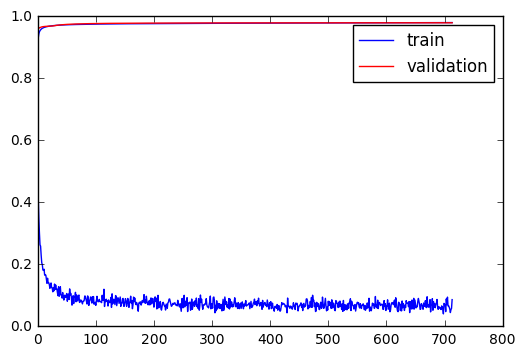

In [40]:
#(0.036388177424669266, 0.9802048802375793) for learning rate 0.005
#data_accuracy= 0.976664662361145 validation_accuracy= 0.9778531193733215 loss function= 0.05492367595434189 for learning 0.001
#(0.14226588606834412, 0.9712700843811035) for learning rate 0.0001
import matplotlib.pyplot as p 
p.plot(loss,'b-', label="train")
p.plot(data_acc_log,'b-')
p.plot(validation_acc_log,'r-',label ="validation")
p.legend(numpoints = 1)
p.show()


In [ ]:
#
def loss_func_test(n_iterations,learning_rate,fix_decay_regularizer,batch_size):
    
    m, n, k = trainData.shape
    n_epoch = int(n_iterations*batch_size/m)
    
    accuracy_log = np.zeros(n_epoch)
    loss = np.zeros(n_epoch)

    #Data (concatenate a 28x28 training data point to 1x(784))
    x_in = tf.constant(trainData.reshape(-1,n*k),dtype=tf.float32, name="dataset_in")
    y_in = tf.constant(trainTarget,dtype=tf.float32, name="true_value")
        
    #Weights
    w = tf.Variable(tf.zeros([n*k, 1], dtype=np.float32), name="weight")
    b = tf.Variable(tf.zeros([1], dtype=np.float32), name="bias")
    
    if fix_decay_regularizer:
        decaybias = 0
    else:
        decaybias = 0.01 #tf.Variable(0.01, name="decay_regularizer")
    
    #optimizer
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
                
    #Loss functions
    y_pred = tf.add(tf.matmul(x_in,w),b)
    loss_weight_decay=tf.nn.l2_loss(w) #0 anyways %loss_weight_decay=h*tf.square(tf.norm(w,ord=2)) #0 anyways
    cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(logits= y_pred,labels = y_in)
    loss_total = tf.reduce_mean(tf.add(cross_entropy,tf.multiply(decaybias,loss_weight_decay)))
    
    #Data Loggers
    acc, acc_log = tf.metrics.accuracy(labels=y_in, predictions=tf.round(tf.sigmoid(y_pred)))
        
    #Train
    train = optimizer.minimize(loss_total)
    
    #initialized all vars
    init = tf.global_variables_initializer()
    
    #run!
    with tf.Session() as sess:
        sess.run(tf.local_variables_initializer())
        sess.run(init)
        for epoch in range(n_epoch):
                #every 100 epoch, update the user
            if epoch % 1000 == 0:
                print("epoch=",epoch,"accuracy=",sess.run(acc_log), "loss=",loss_total.eval())
            sess.run(train)
            accuracy_log[epoch] = sess.run(acc_log)
            loss[epoch] = sess.run(loss_total)
        return loss,accuracy_log

In [ ]:
acc_log = np.zeros(len(trainData))
loss = np.zeros(len(trainData))
loss,acc_log= loss_func_test(3500,0.005,False,3500) 
import matplotlib.pyplot as p 
p.plot(loss,'b-', label="loss")
p.plot(acc_log,'r-', label="accuracy")
p.legend(numpoints = 1)
p.show()